# **Семинар 5 — Изучение механизма внимания и его применение в NLP**
---

#### **Цель семинара**

На этом семинаре мы реализуем механизм внимания (attention) с нуля на NumPy, чтобы понять его математические основы. Этот семинар вдохновлен подходом Джоэля Граса в его книге "Data Science from Scratch" (
Data Science. Наука о данных с нуля). Мы пройдём путь от простого **Scaled Dot-Product Attention** до полноценного **Multi-Head Attention**, сравним нашу реализацию с PyTorch и применим её к задаче машинного перевода, где они изначально и были предложены.

**Зачем реализовывать Attention с нуля на NumPy?**

В реальных проектах вы будете использовать высокооптимизированные фреймворки, такие как PyTorch или TensorFlow. Однако реализация "с нуля" на NumPy — это лучший способ:

1.  Глубоко понять, какие математические операции происходят "под капотом".
2.  **Увидеть сложность**: Наглядно понять, почему Attention имеет квадратичную сложность O(n²) и где находятся "узкие места".
3.  **Оценить фреймворки**: После самостоятельной реализации вы будете лучше понимать, какую огромную работу по оптимизации для вас делают современные библиотеки.

Наша цель сегодня — не написать самый быстрый код или решить конкретную задачу, а досконально разобраться в механизме.

**План семинара**

1.  Интуитивный пример внимания в тексте
2.  Реализация Scaled Dot-Product Attention на NumPy
3.  Разбор и визуализация одной из самых важных концепций для генеративных моделей - маскирование
4.  Разработка Multi-Head Attention
5.  Интерактивная визуализация "голов" внимания
6.  Реализация и визуализация позиционного кодирования
7.  Cross-Attention для выравнивания слов применительно задаче машинного перевода
8.  Бенчмарк производительности NumPy vs PyTorch
9.  Итоги и выводы

-----



### **0. Установка и импорт библиотек**

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from tqdm.notebook import tqdm
import warnings

# Интерактивные виджеты
import ipywidgets as widgets
from ipywidgets import interact

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Фиксируем seed для воспроизводимости
np.random.seed(42)  # 42 - Ответ на главный вопрос жизни, вселенной и всего такого)
torch.manual_seed(42)


-----

### **1. Интуиция механизма внимания**

Представьте, что вы читаете предложение: **"Нейронные сети изучают сложные зависимости в данных"**.

При обработке слова "зависимости", вашему мозгу важно обратить внимание на другие слова, чтобы понять его полный контекст:

  * **"сложные"**: Какие зависимости? Сложные.
  * **"изучают"**: Что делают с зависимостями? Изучают.
  * **"в данных"**: Зависимости в чём? В данных.

Attention — это механизм, который позволяет модели делать то же самое: взвешивать важность других слов в последовательности для обработки текущего слова. Визуализируем пример обработки возможного внимания одной из голов трансформера.

[Дополнительная визуализация (Neural networks learn complex relationships in data.)](https://poloclub.github.io/transformer-explainer/)

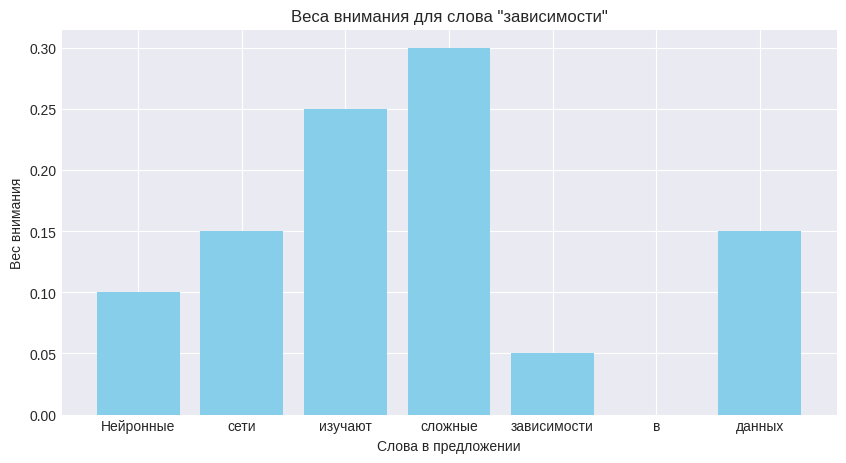

In [ ]:
sentence_rus = ["Нейронные", "сети", "изучают", "сложные", "зависимости", "в", "данных"]
target_word = "зависимости"

# Упрощенно определим важность других слов для слова "зависимости"
attention_weights_rus = {
    "Нейронные": 0.10,
    "сети": 0.15,
    "изучают": 0.25,     # Что делают с зависимостями?  Важно!
    "сложные": 0.30,     # Какие зависимости?           Очень важно!
    "зависимости": 0.05, # Само слово
    "в": 0.0,
    "данных": 0.15       # Зависимости в чем?           Важно!
}

plt.figure(figsize=(10, 5))
plt.bar(attention_weights_rus.keys(), attention_weights_rus.values(), color='skyblue')
plt.title(f'Веса внимания для слова "{target_word}"')
plt.ylabel('Вес внимания')
plt.xlabel('Слова в предложении')
plt.xticks(rotation=0)
plt.show()

---

### **2. Математические основы: Scaled Dot-Product Attention**

Формально, механизм внимания вычисляется через три компонента (матрицы):

  * **Query (Q)**: "Что я ищу?" (Вектор текущего слова)
  * **Key (K)**: "Что я предлагаю?" (Векторы всех слов, на которые мы можем обратить внимание)
  * **Value (V)**: "Какую информацию я несу?" (Векторы всех слов, которые мы будем усреднять)

Формула **Scaled Dot-Product Attention**:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Где:

  - $QK^T$ — матрица схожести (score) между запросами и ключами.
  - $\\sqrt{d\_k}$ — масштабирование для стабильности softmax.
  - $V$ — матрица значений, которые мы взвешенно суммируем.

Размер выхода: (4, 8)
Размер весов: (4, 4)


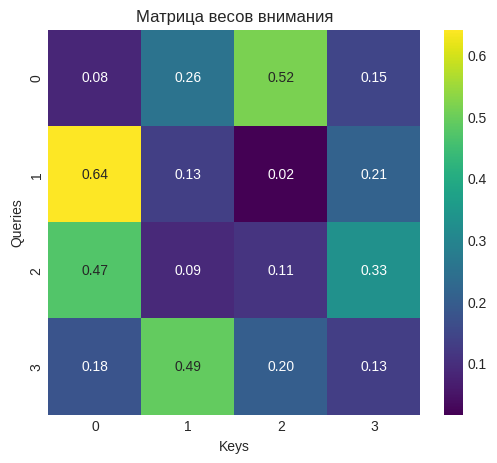

In [ ]:
def scaled_dot_product_attention_numpy(Q, K, V, mask=None):
    """
    Реализация Scaled Dot-Product Attention на NumPy.

    Args:
        Q: Query матрица [seq_len_q, d_k]
        K: Key матрица [seq_len_k, d_k]
        V: Value матрица [seq_len_v, d_v] (seq_len_k == seq_len_v)
        mask: Маскирование [seq_len_q, seq_len_k]

    Returns:
        output: Результат внимания [seq_len_q, d_v]
        attention_weights: Веса внимания [seq_len_q, seq_len_k]
    """
    # Шаг 1: Вычисляем scores (схожесть между Q и K) и масштабируем
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.T) / np.sqrt(d_k)

    # Шаг 2: Применяем маску (если есть)
    if mask is not None:
        scores += (mask * -1e9)  # Большое отрицательное число станет ~0 после softmax

    # Шаг 3: Применяем softmax для получения весов внимания
    def softmax(x, axis=-1):
        """Численно стабильный softmax"""
        exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
        return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

    attention_weights = softmax(scores, axis=-1)

    # Шаг 4: Применяем веса к values
    output = np.matmul(attention_weights, V)

    return output, attention_weights

# Тестируем
seq_len, d_k, d_v = 4, 8, 8
Q = np.random.randn(seq_len, d_k)
K = np.random.randn(seq_len, d_k)
V = np.random.randn(seq_len, d_v)

output, weights = scaled_dot_product_attention_numpy(Q, K, V)  # пока что без маски
print("Размер выхода:", output.shape)
print("Размер весов:", weights.shape)

# Визуализация весов
plt.figure(figsize=(6, 5))
sns.heatmap(weights, annot=True, fmt='.2f', cmap='viridis')
plt.title('Матрица весов внимания')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()

-----

### **3. Маскирование: Causal Attention Mask**

В задачах генерации текста (например, в декодере Трансформера) модель не должна "подсматривать в будущее". Для этого используется **causal маска**, которая обнуляет внимание к последующим токенам.

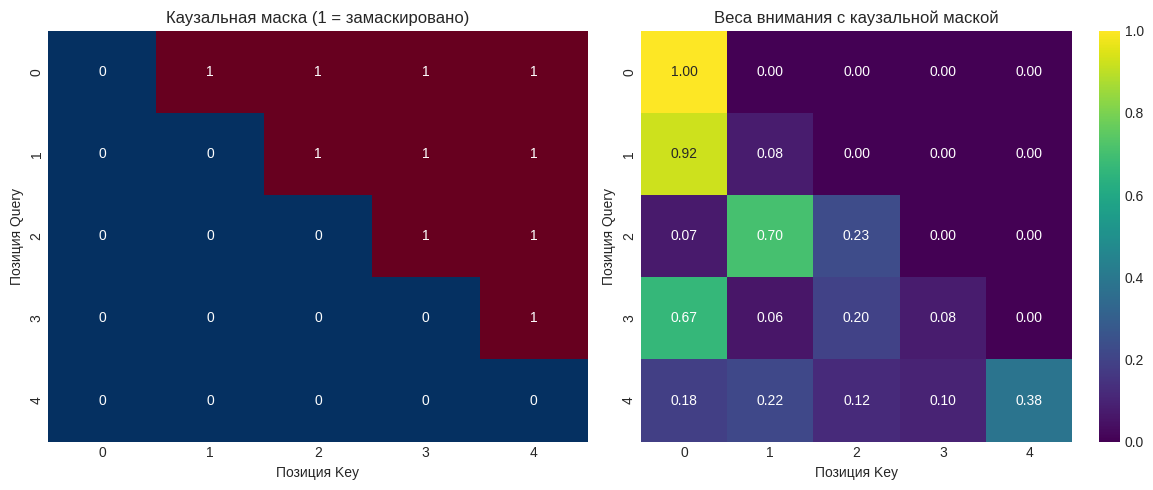

In [ ]:
def create_causal_mask(seq_len):
    """
    Создаёт causal маску для предотвращения внимания к будущим позициям.
    Маска имеет 1 в тех позициях, которые нужно замаскировать.
    """
    mask = np.triu(np.ones((seq_len, seq_len)), k=1)
    return mask

# Демонстрация
seq_len = 5
causal_mask = create_causal_mask(seq_len)

# Применяем маску к attention
Q_masked = np.random.randn(seq_len, 8)
K_masked = np.random.randn(seq_len, 8)
V_masked = np.random.randn(seq_len, 8)
_, masked_attention = scaled_dot_product_attention_numpy(Q_masked, K_masked, V_masked, mask=causal_mask)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(causal_mask, annot=True, fmt='.0f', cmap='RdBu_r', cbar=False, ax=ax1)
ax1.set_title('Каузальная маска (1 = замаскировано)')
ax1.set_xlabel('Позиция Key')
ax1.set_ylabel('Позиция Query')

sns.heatmap(masked_attention, annot=True, fmt='.2f', cmap='viridis', ax=ax2)
ax2.set_title('Веса внимания с каузальной маской')
ax2.set_xlabel('Позиция Key')
ax2.set_ylabel('Позиция Query')

plt.tight_layout()
plt.show()

> **Интерпретация:**
- Позиция `t=0` может смотреть только на себя
- Позиция `t=1` может смотреть на `t=0 и t=1`
- Позиция `t=2` (третья строка) может смотреть на `t=0, t=1, t=2`
- И так далее...

-----



### **4. Multi-Head Attention**

Идея Multi-Head Attention — позволяет модели одновременно фокусироваться на разных аспектах информации. Каждая "голова" учится своему паттерну матрицы внимания.

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O \\
$$

$$
\text{где каждая голова }
$$

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

In [ ]:
class MultiHeadAttention:
    """ Реализация Multi-Head Attention на NumPy. """
    def __init__(self, d_model, n_heads):
        """
        Args:
            d_model: Размерность модели
            n_heads: Количество голов внимания
        """

        assert d_model % n_heads == 0, "d_model должен быть кратен n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Размерность на голову

        # Инициализируем веса (Метод инициализации Xavier)
        limit = np.sqrt(6 / (d_model * 2))
        self.W_Q = np.random.uniform(-limit, limit, (d_model, d_model))
        self.W_K = np.random.uniform(-limit, limit, (d_model, d_model))
        self.W_V = np.random.uniform(-limit, limit, (d_model, d_model))
        self.W_O = np.random.uniform(-limit, limit, (d_model, d_model))

    def forward(self, query, key, value, mask=None):
        """
        Прямой проход (Forward pass) Multi-Head Attention.

        Args:
            query: [batch_size, seq_len, d_model]
            key: [batch_size, seq_len, d_model]
            value: [batch_size, seq_len, d_model]
            mask: маскирование

        Returns:
            output
            weights_by_head
        """
        batch_size = query.shape[0]
        seq_len_q = query.shape[1]
        seq_len_k = key.shape[1]

        # 1. Линейные проекции
        Q = np.matmul(query, self.W_Q)
        K = np.matmul(key, self.W_K)
        V = np.matmul(value, self.W_V)

        # 2. Разделение на головы: [batch, seq_len, d_model] -> [batch, n_heads, seq_len, d_k]
        Q = Q.reshape(batch_size, seq_len_q, self.n_heads, self.d_k).transpose(0, 2, 1, 3)
        K = K.reshape(batch_size, seq_len_k, self.n_heads, self.d_k).transpose(0, 2, 1, 3)
        V = V.reshape(batch_size, seq_len_k, self.n_heads, self.d_k).transpose(0, 2, 1, 3)

        # 3. Применение Scaled Dot-Product Attention для всех голов сразу
        # Q: [b, h, s_q, d_k], K.T: [b, h, d_k, s_k] -> scores: [b, h, s_q, s_k]
        scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(self.d_k)
        if mask is not None:
            scores += mask * -1e9

        attention_weights = self._softmax(scores)

        # weights: [b, h, s_q, s_k], V: [b, h, s_k, d_k] -> attended: [b, h, s_q, d_k]
        attended = np.matmul(attention_weights, V)

        # 4. Конкатенация голов
        # attended: [b, h, s_q, d_k] -> [b, s_q, h, d_k] -> [b, s_q, d_model]
        concat_attention = attended.transpose(0, 2, 1, 3).reshape(batch_size, seq_len_q, self.d_model)

        # 5. Финальная линейная проекция
        output = np.matmul(concat_attention, self.W_O)

        # attention_weights имеет размерность [batch, n_heads, seq_len_q, seq_len_k]
        # Для визуализации вернем список весов для каждой головы
        weights_by_head = [attention_weights[:, h, :, :] for h in range(self.n_heads)]

        return output, weights_by_head

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

-----

### **5. Интерактивная Визуализация "Голов" Внимания**

С помощью виджета мы можем интерактивно посмотреть, на какие разные паттерны фокусируется каждая из "голов".

In [ ]:
# Создаем данные для визуализации
batch_size, seq_len, d_model, n_heads = 1, 8, 128, 8
mha = MultiHeadAttention(d_model, n_heads)
x_vis = np.random.randn(batch_size, seq_len, d_model)
_, attn_weights_vis = mha.forward(x_vis, x_vis, x_vis)

# Интерактивная функция для отрисовки
def plot_interactive_head(head_idx):
    plt.figure(figsize=(6, 5))
    sns.heatmap(attn_weights_vis[head_idx][0], cmap='viridis', vmin=0, vmax=1)
    plt.title(f'Паттерн внимания для Головы {head_idx + 1}')
    plt.ylabel('Query позиция')
    plt.xlabel('Key позиция')
    plt.show()

# Создаем и отображаем слайдер
head_options = [(f"Голова {i+1}", i) for i in range(n_heads)]

interact(plot_interactive_head, head_idx=widgets.SelectionSlider(
    options=head_options,
    value=0,
    description='Выберите:',
    continuous_update=False
));

interactive(children=(SelectionSlider(continuous_update=False, description='Выберите:', options=(('Голова 1', …

-----

### **6. Позиционное кодирование**

Внимание по своей природе инвариантно (не учитывает) к порядку элементов. Чтобы модель знала о позициях токенов, мы добавляем **позиционное кодирование** к их эмбеддингам. Классическим подходом является синусоидное кодирование, которое мы обсуждали на лекции

$$PE_{(pos,2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos,2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

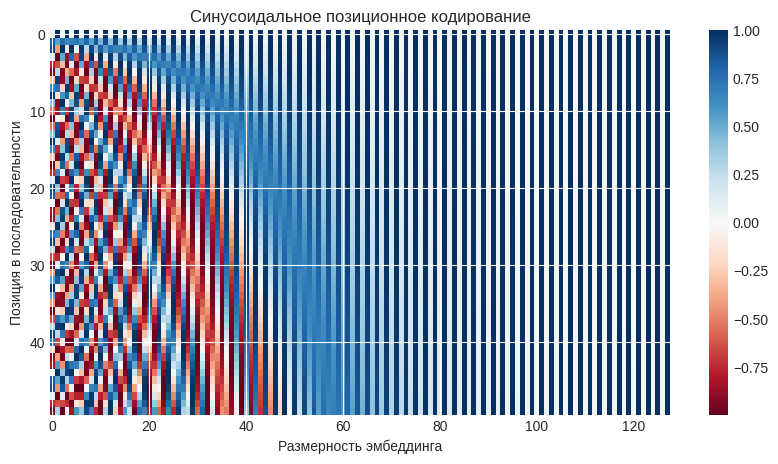

In [ ]:
def positional_encoding(seq_len, d_model):
    PE = np.zeros((seq_len, d_model))
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            denominator = np.power(10000, i / d_model)
            PE[pos, i] = np.sin(pos / denominator)
            if i + 1 < d_model:
                PE[pos, i + 1] = np.cos(pos / denominator)
    return PE

# Генерируем и визуализируем
pe = positional_encoding(seq_len=50, d_model=128)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pe, cmap='RdBu', aspect='auto')
ax.set_title('Синусоидальное позиционное кодирование')
ax.set_xlabel('Размерность эмбеддинга')
ax.set_ylabel('Позиция в последовательности')
plt.colorbar(im, ax=ax)
plt.show()

-----

### **7. Применение: Cross-Attention для выравнивания слов**

Теперь применим наш механизм к более осмысленной задаче. Мы посмотрим, как **Cross-Attention** может помочь в **машинном переводе**, находя соответствия (выравнивание) между словами в двух разных языках.

**Задача:** Модель должна понять, какие слова в английском предложении ("I love NLP") соответствуют словам в русском ("Я люблю НЛП").

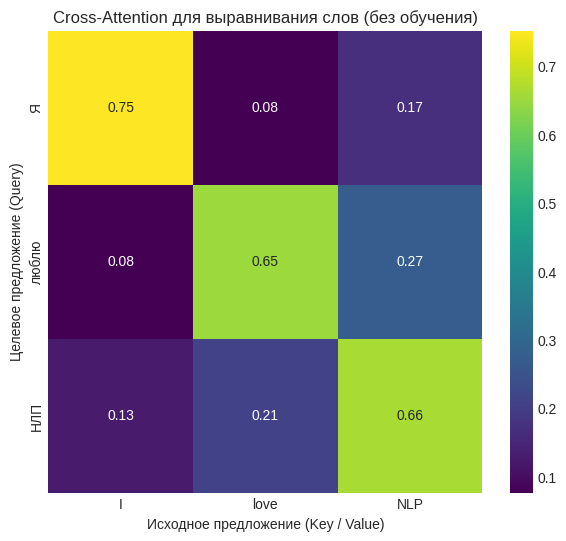

In [ ]:
# 1. Создаем словари
vocab_src = ['<PAD>', 'I', 'love', 'NLP']
vocab_tgt = ['<PAD>', 'Я', 'люблю', 'НЛП']
src_to_idx = {token: idx for idx, token in enumerate(vocab_src)}
tgt_to_idx = {token: idx for idx, token in enumerate(vocab_tgt)}

# 2. Индексируем предложения
src_seq = [src_to_idx[s] for s in ['I', 'love', 'NLP']]
tgt_seq = [tgt_to_idx[s] for s in ['Я', 'люблю', 'НЛП']]

# 3. Создаем "псевдо-эмбеддинги"
d_model = 64
n_heads = 4
embedding_src = np.random.randn(len(vocab_src), d_model)
embedding_tgt = np.random.randn(len(vocab_tgt), d_model)

# 4. Готовим Q, K, V для Cross-Attention
# Query - из целевой последовательности (русской), Key и Value - из исходной (английской)
query = np.array([embedding_tgt[i] for i in tgt_seq])[np.newaxis, :, :]
key = np.array([embedding_src[i] for i in src_seq])[np.newaxis, :, :]
value = key # В стандартном attention K и V из одного источника

# 5. Пропускаем через модель
attention_model = MultiHeadAttention(d_model, n_heads)
_, cross_attention_weights = attention_model.forward(query, key, value)

# 6. Визуализация выравнивания (для одной из голов)
plt.figure(figsize=(7, 6))
sns.heatmap(cross_attention_weights[0][0], cmap='viridis', annot=True, fmt=".2f",
            xticklabels=vocab_src[1:],
            yticklabels=vocab_tgt[1:])
plt.title('Cross-Attention для выравнивания слов (без обучения)')
plt.xlabel('Исходное предложение (Key / Value)')
plt.ylabel('Целевое предложение (Query)')
plt.show()

> **Вывод:** Паттерн внимания пока случаен, так как веса не обучены. Однако, в процессе обучения модель усилила бы значения на диагонали, научившись сопоставлять "Я" с "I", "люблю" с "love" и т.д.

> Однако если взгянуть глубже, то мы бы увидели паттерны внимания разных голов. Например тех, которые связывают подлежащее и сказуемое, местоимение с сущностью и так далее. Тем самым фиксируя суть стоящую за предложением, а энкодер и декодер сделали бы свое дело для генерации правильного предложения на другом языке

-----



### **8. Бенчмарк производительности: NumPy vs PyTorch**

Давайте сравним скорость работы нашей "наивной" NumPy-реализации с оптимизированной версией из PyTorch.

Бенчмарк:   0%|          | 0/5 [00:00<?, ?it/s]

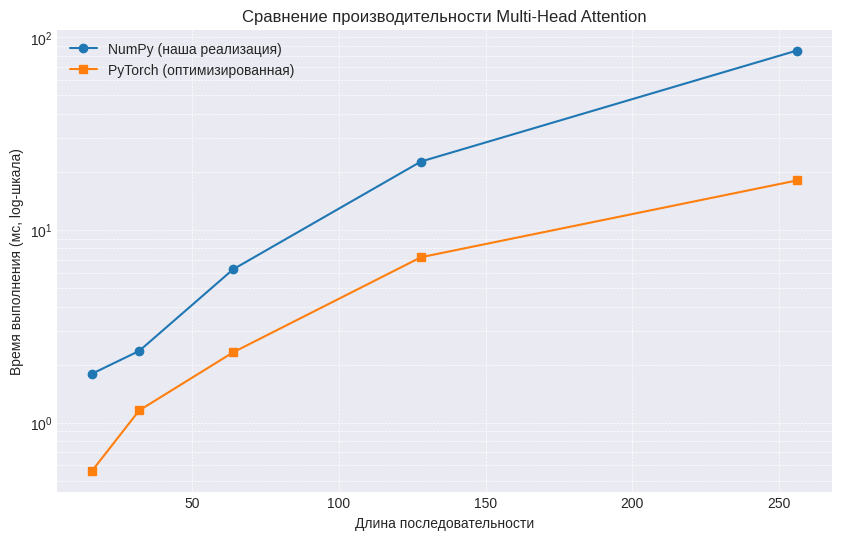

In [ ]:
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class PyTorchMultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
    def forward(self, query, key, value):
        return self.mha(query, key, value)

def benchmark(seq_lengths=[16, 32, 64, 128, 256]):
    results = {'seq_len': [], 'numpy_time': [], 'pytorch_time': []}
    d_model, n_heads, batch_size, n_iter = 128, 8, 4, 10

    for seq_len in tqdm(seq_lengths, desc="Бенчмарк"):
        x_np = np.random.randn(batch_size, seq_len, d_model).astype(np.float32)
        x_torch = torch.tensor(x_np)

        # NumPy
        mha_numpy = MultiHeadAttention(d_model, n_heads)
        start = time.time()
        for _ in range(n_iter): mha_numpy.forward(x_np, x_np, x_np)
        results['numpy_time'].append((time.time() - start) / n_iter * 1000)

        # PyTorch
        mha_pytorch = PyTorchMultiHeadAttention(d_model, n_heads)
        with torch.no_grad():
            start = time.time()
            for _ in range(n_iter): mha_pytorch(x_torch, x_torch, x_torch)
            results['pytorch_time'].append((time.time() - start) / n_iter * 1000)

        results['seq_len'].append(seq_len)

    return results

benchmark_results = benchmark()

# Визуализация результатов (теперь будет работать)
plt.figure(figsize=(10, 6))
plt.plot(benchmark_results['seq_len'], benchmark_results['numpy_time'], 'o-', label='NumPy (наша реализация)')
plt.plot(benchmark_results['seq_len'], benchmark_results['pytorch_time'], 's-', label='PyTorch (оптимизированная)')
plt.xlabel('Длина последовательности')
plt.ylabel('Время выполнения (мс, log-шкала)')
plt.title('Сравнение производительности Multi-Head Attention')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

-----

### **9. Итоги и выводы**

На этом семинаре мы:
- [x] **Разобрали математику механизма внимания**.
- [x] **Реализовали** с нуля на NumPy `Scaled Dot-Product` и `Multi-Head Attention`.
- [x] **Поняли и визуализировали** каузальные маски и позиционное кодирование.
- [x] **Сделали интерактивную визуализацию матриц внимания**, чтобы исследовать паттерны разных "голов".
- [x] **Применили** Cross-Attention к практической задаче машинного перевода.
- [x] **Сравнили производительность** и увидели важность оптимизированных библиотек.

**Ключевые выводы:**

1.  **Attention — это механизм выравнивания**: Он позволяет находить релевантные части во входной последовательности для каждой части выходной.
2.  **Multi-Head позволяет** фокусироваться на разных аспектах (синтаксис, семантика и т.д.) одновременно.
3.  **Квадратичная сложность O(n²)** — главное ограничение для длинных последовательностей, что наглядно показал бенчмарк.
4.  **Позиционное кодирование критично** для понимания порядка слов.

#### **Полезные ресурсы:**

1.  [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) — лучшая визуализация
2.  [Attention Is All You Need](https://arxiv.org/abs/1706.03762) — оригинальная статья
3.  [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) — построчный разбор
4.  [BertViz](https://github.com/jessevig/bertviz) — инструмент визуализации attention